In [2]:
from FCA import *

## Generate FCA dynamics

In [2]:
# pred_iter: total iteration for the FCA model, used for label
# train_iter: the iteration for baseline model, usually less than FCA_iter
# X: a list of graph structure (for each graph, length = k^2 if num_nodes=k)
# return: y (train_iter), baseline_width (pred_iter), si_j (configuration of node j at iteration i)
# quartile, width 
def datagen_FCA_dynamics(num_nodes, kappa, pred_iter, train_iter, file_name, X):
    file = open(file_name, 'w+', newline='')
    header = ["y", "baseline_width"]
    for i in range(train_iter):
        for j in range(num_nodes):
            header.append("s" + str(i + 1) + "_" + str(j + 1))
    for i in range(train_iter):
        header.append("q1_s"+ str(i + 1))
        header.append("q2_s"+ str(i + 1))
        header.append("q3_s"+ str(i + 1))
        header.append("width_s"+ str(i + 1))
        
    with file:
        write = csv.writer(file)
        write.writerow(header)
        for i in range(X.shape[1]): #X.shape[1]: total number of graphs
                                    #X.shape[0]: num_nodes^2
            G=nx.from_pandas_adjacency(pd.DataFrame(X[:,i].reshape(num_nodes, -1)))
            G=nx.Graph(G)
            col = np.random.randint(0,kappa,size=num_nodes)
            
            sample = []
            
            states, label = FCA(G, col, kappa, pred_iter)
            width = width_compute(states[pred_iter - 1], kappa)
            y = False
            if (width < floor(kappa / 2)):  # half circle concentration
                y = True
            sample.append(y)

            baseline_width = width_compute(states[train_iter - 1], kappa)
            baseline = False
            if (baseline_width < floor(kappa / 2)):  # half circle concentration
                baseline = True
            sample.append(baseline)

            for j in range(train_iter):
                sample = sample + list(states[j])
            for j in range(train_iter):
                sample.append(s.quantiles(states[j], n=4)[0])
                sample.append(s.quantiles(states[j], n=4)[1])
                sample.append(s.quantiles(states[j], n=4)[2])
                sample.append(width_compute(states[j], kappa))
    
            write.writerow(sample)

## Generate Graph Features

In [41]:
# X: a list of graph structure (for each graph, length = k^2 if num_nodes=k)
# num_edges, num_nodes, min_degree, max_degree, diameter
def datagen_graph_features(num_nodes, file_name, X):
    # generate the toy dataset
    file = open(file_name, 'w+', newline='')

    header = ["num_edges", "num_nodes", "min_degree", "max_degree", "diameter", 
              "degree_assortativity_coef", "num_clique", "avg_clustering_coef", 
              "density"]
    for i in ["degree_centrality", "eigenvector_centrality", "betweenness_centrality", 
              "closeness_centrality", "clustering", "degree"]:
        for j in range(num_nodes):
            header.append(i + "_n" + str(j + 1))
    
    with file:
        write = csv.writer(file)

        write.writerow(header)
        for i in range(X.shape[1]): #X.shape[1]: total number of graphs
                                    #X.shape[0]: num_nodes^2
            G=nx.from_pandas_adjacency(pd.DataFrame(X[:,i].reshape(num_nodes, -1)))
            G=nx.Graph(G)

            num_edges = G.number_of_edges()
            min_degree = min(list(G.degree), key=lambda x: x[1])[1]
            max_degree = max(list(G.degree), key=lambda x: x[1])[1]
            diameter = nx.diameter(G)
            
            degree_assortativity_coef = nx.degree_assortativity_coefficient(G)
            num_clique = nx.graph_clique_number(G)
            avg_clustering_coef = nx.average_clustering(G)
            #small_world_coef = nx.omega(G)
            density = nx.density(G)

            sample = [num_edges, num_nodes, min_degree, max_degree, diameter,
                      degree_assortativity_coef, num_clique, avg_clustering_coef, 
                      density]
            
            node_feature = []
            node_feature.append(list(nx.degree_centrality(G).values()))
            node_feature.append(list(nx.eigenvector_centrality(G, tol=1.0e-3).values()))
            node_feature.append(list(nx.betweenness_centrality(G).values()))
            node_feature.append(list(nx.closeness_centrality(G).values()))
            node_feature.append(list(nx.clustering(G).values()))
            node_feature.append(list(dict(G.degree()).values()))
            sample = sample + list(np.array(node_feature).reshape(1, -1)[0])

            write.writerow(sample)

## Generate graph2vec

In [4]:
def datagen_g2v(num_nodes, file_name, dimensions, X):
    df = pd.DataFrame()
    for i in range(X.shape[1]):
        G=nx.from_pandas_adjacency(pd.DataFrame(X[:,i].reshape(num_nodes, -1)))
        G=nx.Graph(G)
        graph2vec_model = Graph2Vec(dimensions=dimensions, min_count = 1)
        graph2vec_model.fit([G])
        df = df.append(pd.Series(graph2vec_model.get_embedding()[0]), ignore_index=True)
    df.to_csv(file_name, index = False)

## Generate node2vec

In [37]:
from karateclub import Node2Vec
def datagen_n2v(num_nodes, file_name, dimensions, X):
    df = pd.DataFrame()
    
    header = []
    for i in range(num_nodes):
        for j in range(dimensions):
            header.append("n"+str(i)+"d"+str(j))
            
    for i in range(X.shape[1]):
        G=nx.from_pandas_adjacency(pd.DataFrame(X[:,i].reshape(num_nodes, -1)))
        G=nx.Graph(G)
        node2vec_model = Node2Vec(dimensions = dimensions)
        node2vec_model.fit(G)
        df = df.append(pd.Series(node2vec_model.get_embedding().reshape(1, -1)[0]), ignore_index=True)
    df.columns = header
    df.to_csv(file_name, index = False)

## Random Graph Generator

In [205]:
import random
X = []
n = 500
while n > 0:
    neighbors = int(random.uniform(1, 8))
    probability = random.uniform(0.1, 0.5)
    G = nx.newman_watts_strogatz_graph(20, neighbors, probability)
    #G = nx.erdos_renyi_graph(20, probability)
    if nx.is_connected(G):
        X.append(np.array(nx.adjacency_matrix(G).todense().reshape(-1, 400))[0])
        n = n-1

# Colored Adjacency Matrix

In [ ]:
num_nodes = 20
kappa = 8
df = pd.DataFrame()
# df_graph: list of adj matrix
# df_dynamics
for i_graph in range(df_graph.shape[1]):
    adj_mx = df_graph[:,i_graph].reshape(num_nodes, -1)
    temp =[]
    for i_state in range(50):
        adj = adj_mx.copy()
        #get dynamics from time 0 to time 50
        col = np.array(df_dynamics.loc[i_graph, 
                                       df_dynamics.columns[0+20*i_state]:df_dynamics.columns[19+20*i_state]])
        
        for i in range(num_nodes):
            adj[i,i]=0
            for j in range(num_nodes):
                if i<j:
                    adj[i,j]=min(abs(col[i]-col[j]),
                                 min(col[i], col[j])+kappa-max(col[i], col[j]))
                    adj[j,i]=min(abs(col[i]-col[j]),
                                 min(col[i], col[j])+kappa-max(col[i], col[j]))
        
        temp.append(adj.reshape(1,-1)[0])
        
    df = df.append(pd.Series(np.array(temp).reshape(1, -1)[0]), ignore_index=True)
df.to_csv(file_name, index = False)

# Shifted Dynamics

In [ ]:
df_temp = df_dynamics_ucla.loc[:, 's1_1':'s50_20'].copy()
temp = np.array(df_temp).reshape(-1, 20)
rst = []
kappa = 8
for i in temp:
    differences = [np.max(i) - np.min(i)]
    shifted_opt = i
    for j in range(1,kappa+1):
        shifted = (np.array(i) + j) % kappa
        diff_curr = np.max(shifted) - np.min(shifted)
        if diff_curr<differences:
            differences = diff_curr
            shifted_opt = shifted
    rst.append(shifted_opt)
df_dynamics_nws_shifted = pd.DataFrame(np.array(rst).reshape(-1, 1000))

# Random

## Draw network with node labels

In [ ]:
df_adj = pd.DataFrame(df_graph.T[0].reshape(20, 20))
G = nx.Graph()
G = nx.from_pandas_adjacency(df_adj)
labels = {}
for n in G.nodes:
        labels[n] = str(n+1)

nx.draw(G,labels = labels, pos = nx.spring_layout(G))

## Percentage of different initial dynamics eventually synchronize on the same graph structure

In [148]:
#change
ntwk = 'Caltech36' # COVID_PPI, Wisconsin87, UCLA26
k=20
sample_size=500

path = "Data/Networks_all_NDL/" + str(ntwk) + '.txt'
G = nn.NNetwork()
G.load_add_edges(path, increment_weights=False, use_genfromtxt=True)
X, embs = G.get_patches(k=k, sample_size=sample_size, skip_folded_hom=True)

num of subgraphs induced on k-paths: 500


In [206]:
X = np.array(X).T
X.shape

(400, 500)

In [212]:
datagen_graph_features(20, "temp.csv", X)

In [213]:
df = pd.read_csv("temp.csv")

In [214]:
df.shape

(500, 129)

In [154]:
np.sum(df.num_edges==190)

0

In [166]:
col_arr = []

In [173]:
n = 0
for i in [7, 6, 5, 4]:
    while n <10:
        col = np.random.randint(0,kappa,size=20)
        if width_compute(col, 8) == i:
            col_arr.append(col)
            n+=1

In [174]:
col_arr

[array([7, 0, 4, 7, 0, 2, 0, 0, 7, 7, 5, 5, 4, 4, 3, 7, 7, 4, 6, 1]),
 array([3, 7, 1, 3, 0, 7, 4, 6, 6, 0, 1, 4, 2, 5, 5, 1, 0, 2, 2, 6]),
 array([0, 0, 2, 2, 1, 2, 6, 3, 0, 5, 6, 4, 5, 6, 0, 1, 3, 1, 4, 7]),
 array([2, 7, 1, 3, 3, 0, 5, 1, 0, 7, 2, 2, 1, 2, 4, 1, 3, 5, 1, 6]),
 array([2, 0, 6, 1, 5, 4, 6, 1, 6, 2, 4, 7, 6, 7, 3, 5, 1, 7, 3, 5]),
 array([2, 1, 6, 0, 2, 3, 0, 6, 6, 4, 6, 1, 5, 1, 7, 4, 4, 0, 7, 3]),
 array([6, 2, 0, 6, 1, 4, 2, 3, 4, 2, 0, 5, 2, 5, 3, 2, 1, 4, 7, 3]),
 array([0, 2, 0, 6, 3, 2, 5, 1, 5, 6, 4, 0, 2, 3, 2, 1, 4, 7, 0, 7]),
 array([3, 5, 5, 1, 1, 4, 7, 5, 1, 5, 2, 4, 6, 2, 5, 2, 3, 0, 3, 0]),
 array([2, 6, 4, 1, 7, 3, 0, 0, 6, 5, 7, 6, 4, 3, 3, 4, 2, 6, 2, 3]),
 array([7, 6, 2, 2, 2, 2, 5, 4, 2, 5, 4, 4, 1, 4, 1, 7, 6, 1, 5, 0]),
 array([7, 5, 5, 2, 2, 1, 7, 4, 3, 3, 0, 7, 1, 1, 0, 0, 0, 1, 4, 5]),
 array([1, 5, 5, 3, 0, 4, 5, 6, 4, 5, 6, 2, 1, 5, 6, 5, 4, 3, 1, 3]),
 array([0, 4, 5, 6, 0, 0, 6, 6, 3, 2, 1, 3, 1, 5, 5, 1, 4, 3, 3, 0]),
 array([2, 5, 0, 1, 

In [208]:
Y_data = []
num_nodes=20 
kappa=8
pred_iter=100
#file_name
#file = open(file_name, 'w+', newline='')
for i in range(500):
    y_temp = []
    G=nx.from_pandas_adjacency(pd.DataFrame(X[:,i].reshape(num_nodes, -1)))
    G=nx.Graph(G)
    for col in col_arr:
        states, label = FCA(G, col, kappa, pred_iter)
        width = width_compute(states[pred_iter - 1], kappa)
        y = False
        if (width < floor(kappa / 2)):  # half circle concentration
            y = True
        y_temp.append(y)
    Y_data.append(np.sum(y_temp)/40)
    print(np.sum(y_temp)/40)

0.55
0.975
0.875
0.775
0.675
0.775
0.95
0.625
0.55
0.575
0.525
0.65
0.975
0.975
0.65
0.475
1.0
1.0
1.0
0.675
0.8
1.0
1.0
0.975
0.625
0.975
1.0
0.7
1.0
0.525
0.925
0.475
0.975
0.95
0.525
1.0
0.975
1.0
1.0
0.75
0.95
0.8
0.95
1.0
1.0
1.0
0.975
0.975
1.0
0.6
0.9
1.0
0.525
1.0
0.975
0.825
0.625
0.55
0.975
0.6
1.0
0.975
0.7
1.0
0.65
1.0
0.775
0.875
1.0
0.95
1.0
0.975
0.975
1.0
1.0
0.525
0.675
0.55
0.6
0.7
1.0
1.0
1.0
1.0
0.6
0.525
1.0
0.975
1.0
0.825
1.0
0.9
1.0
0.925
1.0
1.0
0.7
1.0
0.425
0.575
0.7
0.925
0.975
1.0
1.0
1.0
1.0
0.975
0.75
0.7
1.0
0.975
0.65
1.0
0.5
0.95
0.9
0.95
0.525
0.7
0.975
0.6
0.675
0.975
0.95
1.0
1.0
1.0
0.65
0.95
0.675
0.975
0.55
0.575
1.0
0.6
1.0
1.0
0.9
0.975
1.0
0.525
1.0
0.7
0.675
0.975
0.975
0.975
1.0
0.9
1.0
0.575
1.0
1.0
1.0
0.625
1.0
0.975
1.0
0.975
0.875
0.975
0.575
0.975
1.0
0.525
0.65
1.0
1.0
0.975
0.975
1.0
0.95
1.0
0.975
1.0
0.925
0.85
1.0
1.0
0.95
0.675
1.0
0.625
0.65
0.675
0.65
1.0
0.975
0.775
1.0
0.85
0.5
1.0
1.0
0.675
1.0
0.725
0.975
0.8
0.775
0.6
1.0


(array([  7.,  23.,  37.,  59.,  26.,  14.,  16.,   9.,  19., 290.]),
 array([0.425 , 0.4825, 0.54  , 0.5975, 0.655 , 0.7125, 0.77  , 0.8275,
        0.885 , 0.9425, 1.    ]),
 <BarContainer object of 10 artists>)

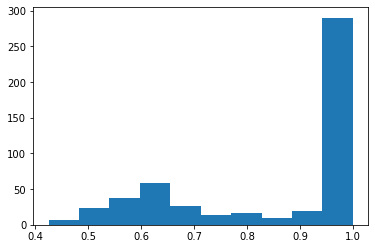

In [209]:
plt.hist(Y_data)

In [217]:
df.index[pd.isnull(df).any(1)]

Int64Index([133, 312, 400], dtype='int64')

In [218]:
from sklearn.model_selection import train_test_split
#df = pd.DataFrame(X.T).loc[:499,:]
#df = pd.read_csv("./my_data/UCLA26_20walk/UCLA26_20walk_graph_features.csv").loc[:499,:]
#df = pd.read_csv("./my_data/UCLA26_20walk/UCLA26_20walk_graph2vec.csv").loc[:499,:]
#df = pd.read_csv("./my_data/UCLA26_20walk/UCLA26_20walk_node2vec.csv").loc[:499,:]

X_train, X_test, y_train, y_test = train_test_split(df.drop(df.index[pd.isnull(df).any(1)]), 
                                                    np.delete(Y_data, df.index[pd.isnull(df).any(1)]), 
                                                    test_size = 0.2)

#X_train, X_test, y_train, y_test = train_test_split(df, Y_data, 
#                                                   test_size = 0.2)

In [219]:
from sklearn.ensemble import RandomForestRegressor
 
 # create regressor object
regressor = RandomForestRegressor(n_estimators = 100, random_state = 0)
 
# fit the regressor with x and y data
regressor.fit(X_train, y_train) 
predicted = regressor.predict(X_test)
import sklearn, math
mse = sklearn.metrics.mean_squared_error(y_test, predicted)
rmse = math.sqrt(mse)
print(mse)
print(rmse)
print(sklearn.metrics.r2_score(y_test, predicted))

0.002311991874999997
0.04808317663174925
0.9324732982725795


In [160]:
sklearn.metrics.r2_score(y_test, [0.5]*100)

-22.200211304807183

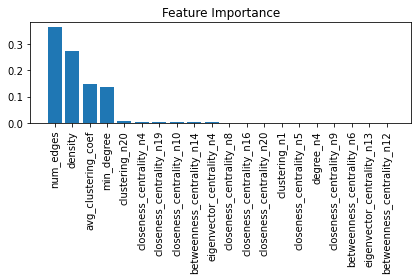

In [220]:
importances = regressor.feature_importances_

sorted_indices = np.argsort(importances)[::-1]

plt.title('Feature Importance')
plt.bar(range(20), list(importances[sorted_indices])[0:20], align='center')
plt.xticks(range(20), list(X_train.columns[sorted_indices])[0:20], rotation=90)
plt.tight_layout()
plt.show()

## Examples
### Sample Graphs

In [28]:
#change
ntwk = 'UCLA26' # COVID_PPI, Wisconsin87, UCLA26
k=25
sample_size=10000

path = "Data/Networks_all_NDL/" + str(ntwk) + '.txt'
G = nn.NNetwork()
G.load_add_edges(path, increment_weights=False, use_genfromtxt=True)
#X, embs = G.get_patches(k=k, sample_size=sample_size, skip_folded_hom=True)
#pickle.dump(X, open('./my_data/toy.pkl', 'wb'))

In [11]:
#adjacency matrix to graph
X = pickle.load(open('./my_data/UCLA26_20walk/UCLA26_20walk_graph.pkl', 'rb'))
G=nx.from_pandas_adjacency(pd.DataFrame(X[:,1].reshape(20, -1)))
G=nx.Graph(G)

dict_values([1, 2, 2, 2, 3, 2, 3, 2, 2, 2, 2, 3, 2, 3, 2, 2, 2, 2, 2, 1])

In [18]:
num_nodes = 20
kappa = 8
pred_iter = 200
train_iter = 50
file_name = "./my_data/nws_20000nodes_1000neighbors_0.7prob/nws_20walk_FCA_dynamics_8kappa.csv"
datagen_FCA_dynamics(num_nodes, kappa, pred_iter, train_iter, file_name, X)
file_name = "./my_data/nws_20000nodes_1000neighbors_0.7prob/nws_20walk_graph_features.csv"
datagen_graph_features(num_nodes, file_name, X)

In [38]:
#file_name = "./my_data/nws_20000nodes_1000neighbors_0.7prob/nws_20walk_graph2vec.csv"
#datagen_g2v(num_nodes, file_name, 16, X)
file_name = "./my_data/nws_20000nodes_1000neighbors_0.7prob/nws_20walk_node2vec.csv"
datagen_n2v(num_nodes, file_name, 4, X)

### NWS

In [9]:
G = nx.newman_watts_strogatz_graph(20000, 1000, 0.7)

edgelist = []
for i in list(G.edges(data=True)):
    edgelist.append([i[0], i[1]])
G = nn.NNetwork()
G.add_edges(edgelist)

num_nodes=20
X, embs = G.get_patches(k=num_nodes, sample_size=10000, skip_folded_hom=True)

In [17]:
X = X1
X.shape

(400, 10000)

## Read csv

In [3]:
fileo = open('./my_data/UCLA26_20walk/UCLA26_20walk_graph.pkl', 'rb')
X = pickle.load(fileo)
fileo.close()

In [5]:
#datagen_FCA_dynamics(num_nodes=20, kappa=8, pred_iter=200, train_iter=50, file_name="temp.csv", X=X)

In [7]:
pd.read_csv("./my_data/UCLA26_20walk/UCLA26_20walk_FCA_dynamics_8kappa.csv")

,num_edges,num_nodes,min_degree,max_degree,diameter,quartile_1,quartile_2,quartile_3,y,baseline_width,...,s50_11,s50_12,s50_13,s50_14,s50_15,s50_16,s50_17,s50_18,s50_19,s50_20
0,24,20,1,4,12,1.00,4.5,6.0,True,False,...,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0
1,21,20,1,3,17,2.00,3.0,6.5,True,False,...,4.0,3.0,3.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0
2,25,20,1,4,7,2.00,3.5,5.0,False,False,...,2.0,1.0,0.0,6.0,7.0,6.0,6.0,3.0,3.0,2.0
3,26,20,1,5,15,3.25,5.0,6.0,True,False,...,2.0,3.0,4.0,4.0,4.0,4.0,4.0,5.0,5.0,5.0
4,25,20,1,4,8,1.00,4.0,6.0,True,False,...,4.0,4.0,4.0,4.0,4.0,3.0,2.0,4.0,4.0,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,23,20,1,4,8,2.00,4.5,6.0,False,False,...,3.0,2.0,3.0,4.0,4.0,4.0,5.0,7.0,0.0,1.0
9996,23,20,1,3,16,2.25,5.0,6.0,True,False,...,2.0,3.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0
9997,22,20,2,3,9,2.00,4.0,6.0,True,True,...,1.0,1.0,0.0,0.0,7.0,6.0,0.0,0.0,7.0,7.0
9998,23,20,1,4,11,1.00,4.5,6.0,True,False,...,6.0,6.0,6.0,6.0,6.0,7.0,0.0,1.0,0.0,2.0


In [26]:
pd.read_csv("./my_data/UCLA26_20walk/UCLA26_20walk_graph_features.csv")

,num_edges,num_nodes,min_degree,max_degree,diameter,degree_assortativity_coef,num_clique,avg_clustering_coef,density,degree_centrality_n1,...,degree_n11,degree_n12,degree_n13,degree_n14,degree_n15,degree_n16,degree_n17,degree_n18,degree_n19,degree_n20
0,24,20,1,4,12,0.282609,3,0.233333,0.126316,0.052632,...,2.0,3.0,2.0,2.0,2.0,3.0,2.0,2.0,2.0,1.0
1,21,20,1,3,17,0.139344,3,0.166667,0.110526,0.052632,...,2.0,3.0,2.0,3.0,2.0,2.0,2.0,2.0,2.0,1.0
2,25,20,1,4,7,-0.139601,3,0.075000,0.131579,0.052632,...,2.0,4.0,2.0,4.0,2.0,3.0,2.0,3.0,3.0,2.0
3,26,20,1,5,15,0.687124,4,0.271667,0.136842,0.052632,...,2.0,3.0,5.0,4.0,4.0,4.0,4.0,2.0,2.0,1.0
4,25,20,1,4,8,0.277778,4,0.191667,0.131579,0.052632,...,4.0,3.0,3.0,4.0,2.0,2.0,3.0,2.0,2.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,23,20,1,4,8,-0.017699,2,0.000000,0.121053,0.105263,...,2.0,3.0,2.0,2.0,2.0,2.0,4.0,2.0,2.0,1.0
9996,23,20,1,3,16,-0.033708,3,0.266667,0.121053,0.052632,...,2.0,2.0,2.0,2.0,2.0,2.0,3.0,2.0,3.0,1.0
9997,22,20,2,3,9,0.541667,3,0.050000,0.115789,0.105263,...,2.0,2.0,2.0,2.0,2.0,3.0,2.0,2.0,2.0,2.0
9998,23,20,1,4,11,0.169444,3,0.150000,0.121053,0.052632,...,3.0,2.0,2.0,2.0,2.0,2.0,3.0,2.0,4.0,1.0


In [26]:
pd.read_csv("./my_data/UCLA26_20walk/UCLA26_20walk_graph2vec_8kappa.csv")

,0.05108866,0.05988675,0.051052254,-0.04901271,-0.05426382,-0.028955922,-0.027386587,0.029444352,-0.04261925,-0.054072067,-0.029566515,0.06210293,-0.029794322,0.009588663,0.056234073,0.027707612
0,0.050570,0.059278,0.050534,-0.048515,-0.053713,-0.028662,-0.027108,0.029145,-0.042186,-0.053523,-0.029266,0.061472,-0.029492,0.009491,0.055663,0.027426
1,0.050897,0.059663,0.050861,-0.048829,-0.054061,-0.028848,-0.027284,0.029334,-0.042460,-0.053870,-0.029456,0.061871,-0.029683,0.009553,0.056024,0.027604
2,0.051148,0.059956,0.051111,-0.049069,-0.054326,-0.028989,-0.027418,0.029478,-0.042668,-0.054134,-0.029601,0.062175,-0.029829,0.009600,0.056299,0.027740
3,0.050802,0.059551,0.050766,-0.048738,-0.053959,-0.028793,-0.027233,0.029279,-0.042380,-0.053769,-0.029401,0.061754,-0.029627,0.009535,0.055918,0.027552
4,0.051084,0.059881,0.051048,-0.049008,-0.054259,-0.028953,-0.027384,0.029442,-0.042615,-0.054067,-0.029564,0.062097,-0.029792,0.009588,0.056229,0.027705
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9994,0.050911,0.059679,0.050875,-0.048842,-0.054075,-0.028855,-0.027291,0.029342,-0.042471,-0.053884,-0.029464,0.061887,-0.029691,0.009555,0.056039,0.027611
9995,0.050517,0.059216,0.050481,-0.048464,-0.053656,-0.028632,-0.027080,0.029115,-0.042142,-0.053467,-0.029235,0.061408,-0.029461,0.009481,0.055604,0.027397
9996,0.050709,0.059442,0.050673,-0.048649,-0.053861,-0.028741,-0.027183,0.029226,-0.042303,-0.053670,-0.029347,0.061641,-0.029573,0.009517,0.055816,0.027502
9997,0.050860,0.059619,0.050824,-0.048794,-0.054021,-0.028827,-0.027264,0.029313,-0.042429,-0.053831,-0.029434,0.061826,-0.029661,0.009546,0.055983,0.027584


In [24]:
pd.read_csv("./my_data/UCLA26_20walk/UCLA26_20walk_node2vec_8kappa.csv")

,0.112406,0.06738,-0.0356143,0.0164471,-0.0935449,-0.0473699,-0.00303751,-0.0474917,-0.00337431,-0.080533,...,0.00680673,0.0709106,-0.106237,0.027484,0.034903,-0.0911181,0.0747142,0.0447065,-0.0899718,-0.0577142
0,0.067645,0.037357,-0.018886,0.020382,-0.057982,-0.034363,-0.007160,-0.036831,0.012210,-0.044096,...,0.000729,0.024370,-0.052273,0.006639,0.018117,-0.051706,0.034759,0.029523,-0.018337,-0.002251
1,0.105516,0.051323,-0.026653,0.000515,-0.067703,-0.056222,-0.012105,-0.068640,0.026029,-0.065621,...,-0.027301,0.028808,-0.083097,-0.000222,-0.012417,-0.059103,0.070943,0.048885,-0.043010,-0.007983
2,0.123405,0.067485,-0.023832,0.056263,-0.123293,-0.067633,0.002800,-0.067409,0.036560,-0.063583,...,-0.020138,0.063171,-0.086018,0.004266,0.031600,-0.051202,0.045323,0.082003,-0.042807,-0.030573
3,0.073229,0.038295,-0.038078,0.039249,-0.077691,-0.043150,0.004113,-0.058222,0.012408,-0.035296,...,0.000335,0.042360,-0.066795,-0.007869,-0.016522,-0.042749,0.036362,0.047342,-0.040080,-0.038061
4,0.103980,0.051037,-0.037367,0.038712,-0.092922,-0.054560,-0.016604,-0.065674,0.008065,-0.061829,...,0.005799,0.039767,-0.059609,0.007863,0.012455,-0.055472,0.037050,0.046283,-0.029312,-0.012593
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9994,0.010125,-0.037433,0.000274,0.024960,0.036638,0.016675,0.022930,-0.040526,0.008589,0.110752,...,-0.020119,-0.028982,0.055818,-0.016725,0.044934,-0.040874,0.003772,-0.056383,0.015136,0.003339
9995,0.028382,-0.038145,-0.006799,0.002025,0.037242,0.012057,0.045409,-0.045270,-0.028847,0.121220,...,-0.013405,-0.010911,0.065789,-0.024614,0.051457,-0.065525,-0.001403,-0.044887,0.016754,0.014407
9996,0.018066,-0.052167,0.009067,0.019752,0.052726,0.007340,0.046300,-0.037755,0.004845,0.118643,...,-0.019752,-0.029908,0.072950,-0.016313,0.053310,-0.067470,-0.002580,-0.062187,0.025682,0.017224
9997,0.030252,-0.038952,-0.003833,0.019933,0.021808,0.029849,0.025227,-0.022579,-0.018044,0.122480,...,-0.029547,-0.014849,0.075526,-0.040029,0.056414,-0.069009,-0.000259,-0.055134,0.025471,0.015710
